In [1]:
import os
import re
import unicodedata

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import sklearn

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix)
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

In [2]:
import nltk
nltk.download('vader_lexicon')  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/harichandanakotnani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Loading and Splitting the data 

In [3]:
def load_imdb_data(path):
    # load data from CSV file
    df = pd.read_csv(path)
    # extract text and label columns
    texts = df['review']
    labels = df['sentiment']
    # map 'positive' and 'negative' labels to 1 and 0, respectively
    labels = labels.map({'positive': 1, 'negative': 0})
    # return DataFrame with text and label columns
    return pd.DataFrame({'text': texts, 'label': labels})

In [4]:
# load the dataset using the function we defined earlier
data = load_imdb_data('IMDB Dataset.csv')

# split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

# reset the index for both train and test DataFrames
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [5]:
print(train[:10])

                                                text  label
0  That's what I kept asking myself during the ma...      0
1  I did not watch the entire movie. I could not ...      0
2  A touching love story reminiscent of In the M...      1
3  This latter-day Fulci schlocker is a totally a...      0
4  First of all, I firmly believe that Norwegian ...      0
5  I don't know how this movie received so many p...      0
6  Nightmare Weekend stars a cast of ridiculous a...      0
7  :::SPOILER ALERT:::<br /><br />Soooo, Arnie's ...      0
8  The people who are bad-mouthing this film are ...      1
9  <br /><br />As usual, I was really looking for...      0


### preprocessing 

Clean the training text

In [7]:
import re
import nltk


def clean(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, email addresses, and phone numbers
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d{10}', '', text)
    
    # Remove special characters, punctuation, and emojis
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'_+', '', text)
    text = re.sub(r'<br\s*\/?>', '', text)
    text = text.replace('br', '')
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove extra white spaces, tabs, and newlines
    text = re.sub(r'\s+', ' ', text)
    
    # Remove language-specific stopwords
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    words = re.findall(r'\w+', text)
    words = [word for word in words if word not in stopwords]
    
    # Stemming
    words = [wnl.lemmatize(word) for word in words]
    
    return ' '.join(words)


In [8]:
train['text'] = train['text'].apply(lambda x: clean(x))
test['text'] = test['text'].apply(lambda x: clean(x))

In [9]:
print(train[:10])

                                                text  label
0  thats kept asking many fight screaming match s...      0
1  watch entire movie could watch entire movie st...      0
2  touching love story reminiscent mood love draw...      1
3  latterday fulci schlocker totally abysmal conc...      0
4  first firmly believe norwegian movie continual...      0
5  dont know movie received many positive review ...      0
6  nightmare weekend star cast ridiculous actor e...      0
7  spoiler alert soooo arnies really good guy inc...      0
8  people badmouthing film dont understand film b...      1
9  usual really looking forward new tvfilm favour...      0


In [10]:
def generate_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    ngrams = list(nltk.ngrams(tokens, n))
    return [' '.join(gram) for gram in ngrams]

In [11]:
train['bigrams'] = train['text'].apply(lambda x: generate_ngrams(x, 2))

### word vectorizer

In [12]:
vectorizer = CountVectorizer(max_features=10000, ngram_range=(2, 2))
X_train_vectors = vectorizer.fit_transform(train['text'])
X_train_vectors

<40000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 753805 stored elements in Compressed Sparse Row format>

In [13]:
X_train_vectors[0]

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [14]:
vectorizer.get_feature_names()[10:30]

/Users/harichandanakotnani/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['absolutely awful',
 'absolutely fantastic',
 'absolutely hilarious',
 'absolutely horrible',
 'absolutely illiant',
 'absolutely love',
 'absolutely loved',
 'absolutely nothing',
 'absolutely perfect',
 'absolutely sense',
 'absolutely stunning',
 'absolutely terrible',
 'academy award',
 'accidentally kill',
 'across board',
 'across country',
 'across movie',
 'across screen',
 'act like',
 'act way']

In [15]:
analyzer = SentimentIntensityAnalyzer()
train['bigram_sentiment'] = train['bigrams'].apply(lambda x: [analyzer.polarity_scores(gram)['compound'] for gram in x])


In [16]:
positive_bigrams = train.explode('bigram_sentiment')[train['label'] == 1]['bigram_sentiment']
negative_bigrams = train.explode('bigram_sentiment')[train['label'] == 0]['bigram_sentiment']

positive_bigrams_mean = positive_bigrams.groupby(positive_bigrams.index).mean()
negative_bigrams_mean = negative_bigrams.groupby(negative_bigrams.index).mean()

print('Top 10 positive bigrams:')
print(positive_bigrams_mean.sort_values(ascending=False)[:10])

print('Top 10 negative bigrams:')
print(negative_bigrams_mean.sort_values(ascending=True)[:10])


/var/folders/7x/qs_7dnj90g55d5h3f4vzdcp00000gn/T/ipykernel_54645/3213857361.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_bigrams = train.explode('bigram_sentiment')[train['label'] == 1]['bigram_sentiment']
/var/folders/7x/qs_7dnj90g55d5h3f4vzdcp00000gn/T/ipykernel_54645/3213857361.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  negative_bigrams = train.explode('bigram_sentiment')[train['label'] == 0]['bigram_sentiment']


Top 10 positive bigrams:
16573    0.401658
14144    0.397809
36740    0.368658
14290    0.362979
31547    0.362963
33311    0.362963
23276    0.351412
36893    0.351365
16262    0.349462
12710    0.348179
Name: bigram_sentiment, dtype: float64
Top 10 negative bigrams:
27791   -0.392827
22604   -0.359557
18834   -0.300046
29971   -0.300046
26177   -0.299444
4647    -0.266767
30999   -0.265643
9651    -0.253060
22203   -0.250850
17093   -0.248315
Name: bigram_sentiment, dtype: float64


#### EDA

/Users/harichandanakotnani/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


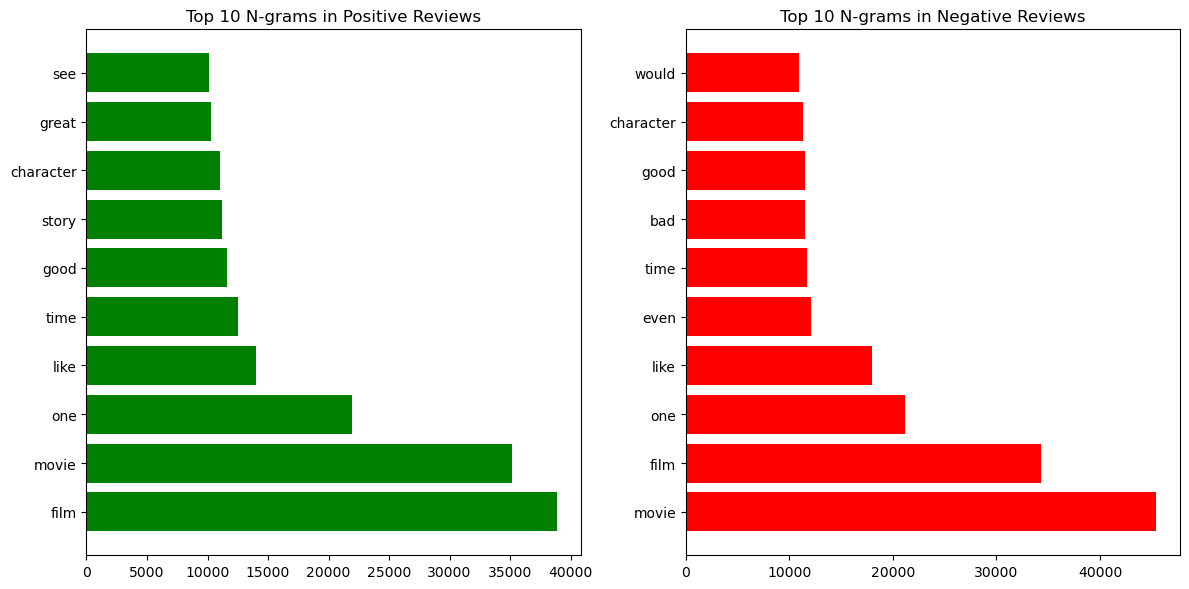

In [17]:
# define the n-gram range and maximum number of features
ngram_range = (1, 2)
max_features = 10000

# instantiate the count vectorizer with the specified n-gram range and maximum number of features
vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

# fit and transform the training data
X_train_vectors = vectorizer.fit_transform(train['text'])

# get the feature names
feature_names = vectorizer.get_feature_names()

# get the top occurring n-grams for positive and negative reviews
top_ngrams_pos = pd.Series(X_train_vectors[train['label']==1].sum(axis=0).A1, index=feature_names).sort_values(ascending=False)[:10]
top_ngrams_neg = pd.Series(X_train_vectors[train['label']==0].sum(axis=0).A1, index=feature_names).sort_values(ascending=False)[:10]

# plot the bar chart for top occurring n-grams in positive and negative reviews
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].barh(top_ngrams_pos.index, top_ngrams_pos.values, color='green')
ax[0].set_title('Top 10 N-grams in Positive Reviews')
ax[1].barh(top_ngrams_neg.index, top_ngrams_neg.values, color='red')
ax[1].set_title('Top 10 N-grams in Negative Reviews')
plt.tight_layout()
plt.show()


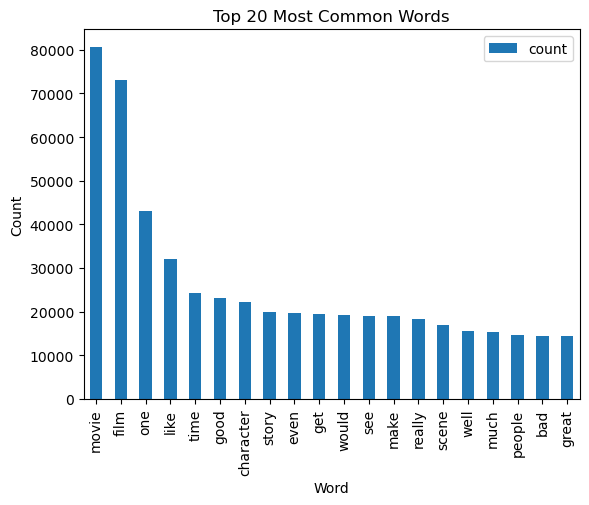

In [18]:
# Word Frequency Analysis
all_reviews = ' '.join(train['text'])

# split the string into individual words
all_words = all_reviews.split()

# count the frequency of each word
word_counts = Counter(all_words)

# create a dataframe of the top 20 most common words
top_words = pd.DataFrame(word_counts.most_common(20), columns=['word', 'count'])

# plot the word frequency distribution
top_words.plot(kind='bar', x='word')
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Multinomial Naive Bayes

Training using our training data

In [19]:
model = MultinomialNB()
model.fit(X_train_vectors, train['label'])

MultinomialNB()

In [20]:
model.score(X_train_vectors, train['label'])

0.868825

### Testing
Vectorize

In [21]:
X_test_vectors = vectorizer.transform(test['text'])
X_test_vectors

<10000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 942523 stored elements in Compressed Sparse Row format>

#### evaluate classifier on test data

In [22]:
y_test_hat = model.predict(X_test_vectors)
y_test_hat

array([0, 1, 0, ..., 1, 0, 0])

#### accuracy score

In [23]:
accuracy_score(test.label, y_test_hat)

0.8571

### Results

In [33]:
print(classification_report(test['label'], y_test_hat))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4961
           1       0.86      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [25]:
print("Confusion Matrix:")
print(confusion_matrix(test.label, y_test_hat))

Confusion Matrix:
[[4238  723]
 [ 706 4333]]


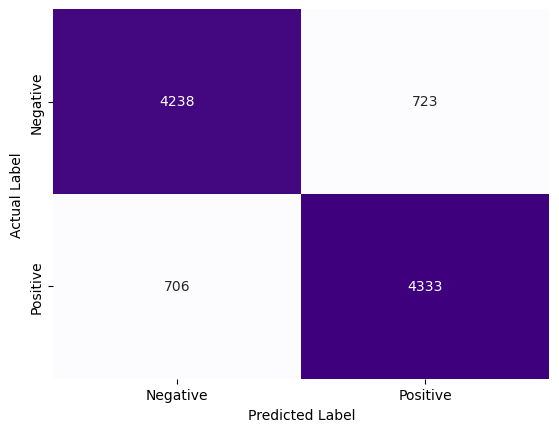

In [26]:
sns.heatmap(pd.DataFrame(confusion_matrix(test.label, y_test_hat)), annot=True, cmap="Purples", fmt="d", cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label');